In [1]:
# Read in Libraries
from __future__ import division, print_function
from logbook import Logger, StreamHandler
import sys
StreamHandler(sys.stdout).push_application()
log = Logger('Logbook')
import shutil, csv, time
timestr = time.strftime("%Y%m%d")
import ujson as json
from keras.layers.advanced_activations import LeakyReLU
import utils; reload(utils)
from utils import *
import gc
# from __future__ import division, print_function
from theano.sandbox import cuda
from vgg16bn import Vgg16BN
from sklearn import metrics
%matplotlib inline

def accuracyfunc(y_act, y_pred):
    return metrics.accuracy_score(np.argmax(y_act, axis=1), np.argmax(y_pred, axis=1))
    
def refresh_directory_structure(name, sub_dirs):
    gdir = os.path.join(path, name)
    if os.path.exists(gdir):
        shutil.rmtree(gdir)
    os.makedirs(gdir)
    for sub_dir in sub_dirs:
        os.makedirs(os.path.join(gdir, sub_dir))


Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# Set Parameters and check files
refresh_directories = False
input_exists = True
full = True
log.info('Set Paramters')
path = "../data/fish/"
batch_size=32
clip = 0.99
bags = 1
load_size = (380, 680)# (360, 640) 

[2017-03-02 21:57:49.245516] INFO: Logbook: Set Paramters


In [3]:
relabels = pd.read_csv("../data/fish/relabel/relabels.csv", sep = " ", header = None, names = ["fname", "dir_from", "dir_to"])
relabels.head(3)

,fname,dir_from,dir_to
0,img_00028,NoF,ALB
1,img_00076,NoF,ALB
2,img_00248,ALB,OTHER


In [4]:
subdir2 = relabels[relabels.fname == 'img_00739.jpg'.split('.')[0]].values.tolist()[0][2]
subdir2 == 'revise'

True

In [5]:
# Create the test and valid directory
if refresh_directories:
    log.info('Create directory structure and validation files')
    sub_dirs = os.listdir(os.path.join(path, 'train-all'))
    if '.DS_Store' in sub_dirs: sub_dirs.remove('.DS_Store')
    refresh_directory_structure('relabel/train', sub_dirs)
    refresh_directory_structure('relabel/valid', sub_dirs)
    for c,row in enumerate(csv.DictReader(open('../image_validation_set.csv'))):
        value = 'relabel/valid' if row['Validation'] == '1' else 'relabel/train'
        subdir1 = row['SubDirectory']
        subdir2 = row['SubDirectory']
        if row['file_name'].split('.')[0] in relabels.fname.values.tolist():
            subdir2 = relabels[relabels.fname == row['file_name'].split('.')[0]].values.tolist()[0][2]
            print(relabels[relabels.fname == row['file_name'].split('.')[0]].values.tolist())
        name_from = os.path.join(path, 'train-all', subdir1, row['file_name'])
        if subdir2 == 'revise':
            name_to   = os.path.join(path, 'relabel/revise', row['file_name'])
            #print(os.path.join(path, value, subdir2, row['file_name']))
        else:
            name_to   = os.path.join(path, value, subdir2, row['file_name'])
            #print(os.path.join(path, value, subdir2, row['file_name']))
        shutil.copyfile(name_from, name_to)
        

In [6]:
# Read in our VGG pretrained model
log.info('Get VGG')
model = vgg_ft_bn(8)

# Create our VGG model
log.info('Create VGG')
vgg640 = Vgg16BN(load_size).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

# get labels
(val_classes, trn_classes, val_labels, trn_labels,
    val_filenames, filenames, test_filenames) = get_classes(path+"relabel/")

# Read in filenames
log.info('Read filenames')
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

[2017-03-02 21:57:49.415932] INFO: Logbook: Get VGG
[2017-03-02 21:57:52.706542] INFO: Logbook: Create VGG
Found 3070 images belonging to 8 classes.
Found 689 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.
[2017-03-02 21:57:53.226019] INFO: Logbook: Read filenames


In [7]:

folder_anno_in = 'darknet/FISH/annos'
# Read in the boxes
anno_classes = ['ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
tmpdict = {}
for c in anno_classes:
    j = json.load(open(os.path.join('..', folder_anno_in, '{}.json'.format(c)), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            tmpdict[l['filename'].split('/')[-1]] = sorted(
               l['annotations'], key=lambda x: x['height']*x['width'])[-1]

bb_json = {k: tmpdict[k] for k in raw_filenames + raw_val_filenames if k in tmpdict}

In [8]:
# make it easy to find the nof dots, by putting themin the middle
#empty_bbox = {'height': 0., 'width': 0., 'x': 1280/2., 'y': 720/2}
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [9]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (load_size[1] / size[0])
    conv_y = (load_size[0] / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [10]:
trn_sizes = [PIL.Image.open(path+'relabel/train/'+f).size for f in filenames]
val_sizes = [PIL.Image.open(path+'relabel/valid/'+f).size for f in val_filenames]
tst_sizes = [PIL.Image.open(path+'relabel/test/'+f).size for f in test_filenames]

In [11]:
sizes = [PIL.Image.open(path+'relabel/train/'+f).size for f in filenames]
raw_val_sizes = [PIL.Image.open(path+'relabel/valid/'+f).size for f in val_filenames]
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Found 689 images belonging to 8 classes.


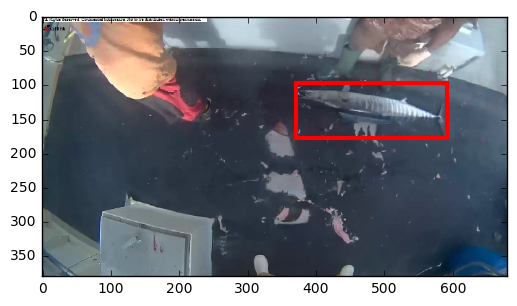

In [12]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

val = get_data(path+'relabel/valid', load_size)
show_bb(500)
#del val
#gc.collect()

In [13]:
log.info('Read in data')
if not input_exists:    
    log.info('Validation - Fetch images; Get VGG output; Write VGG output')    
    val = get_data(path+'relabel/valid', load_size)
    conv_val_feat = vgg640.predict(val, batch_size=16, verbose=1)
    save_array(path+'results/conv_val_relabel_feat.dat', conv_val_feat)
    del val, conv_val_feat
    gc.collect()
    
    log.info('Train - Fetch images; Get VGG output; Write VGG output')
    trn = get_data(path+'relabel/train', load_size)
    conv_trn_feat = vgg640.predict(trn, batch_size=16, verbose=1)    
    del trn
    gc.collect()
    save_array(path+'results/conv_trn_relabel_feat.dat', conv_trn_feat) 
    del conv_trn_feat
    gc.collect()
    
    log.info('Test - Fetch images; Get VGG output; Write VGG output')
    test = get_data(path+'relabel/test', load_size)
    conv_test_feat = vgg640.predict(test, batch_size=16, verbose=1)
    save_array(path+'results/conv_test_relabel_feat.dat', conv_test_feat)     
    del test, conv_test_feat
    gc.collect()

[2017-03-02 21:58:34.241585] INFO: Logbook: Read in data


In [14]:
gc.collect()
conv_val_feat = load_array(path+'results/conv_val_relabel_feat.dat')
conv_trn_feat = load_array(path+'results/conv_trn_relabel_feat.dat') 
conv_test_feat = load_array(path+'results/conv_test_relabel_feat.dat')

In [15]:
conv_trn_feat.shape

(3070, 512, 23, 42)

In [16]:
if full:
    conv_trn_feat = np.concatenate([conv_trn_feat, conv_val_feat])
    trn_labels = np.concatenate([trn_labels, val_labels]) 
    trn_bbox = np.concatenate([trn_bbox, val_bbox])
    
# Our Convolutional Net Architecture
log.info('Create and fit CNN')
p=0.6
# Set up the fully convolutional net (FCN); 
conv_layers,_ = split_at(vgg640, Convolution2D)
nf=128; p=0. # No dropout

[2017-03-02 21:58:43.685783] INFO: Logbook: Create and fit CNN


In [17]:
gc.collect()
nf = 512
p  = 0.3
def create_model():
    inp = Input(conv_layers[-1].output_shape[1:])
    x = MaxPooling2D()(inp)
    x = ZeroPadding2D((1,1))(x)
    x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
    x =   Dropout(p)(x)
    x = BatchNormalization(axis=1)(x)
    #x = MaxPooling2D()(x)
    #x = ZeroPadding2D((1,1))(x)
    #x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
    #x =   Dropout(p)(x)
    #x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D()(x)
    x = ZeroPadding2D((1,1))(x)
    x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
    x =   Dropout(p)(x)
    x = BatchNormalization(axis=1)(x)
    x1 =   MaxPooling2D()(x)
    x1 =   Convolution2D(8,3,3, border_mode='same')(x1)
    x1 =   Dropout(p/2)(x1)
    x1 =   GlobalAveragePooling2D()(x1)
    x = Dropout(p/2)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x_bb = Dense(4, name='bb')(x)
    x_class = Dense(8, activation='softmax', name='class')(x1)
    return inp, x_bb, x_class

## Set up the fully convolutional net (FCN); 
#conv_layers,_ = split_at(vgg640, Convolution2D)
#nf=128; p=0. # No dropout

model = []
predsls = []
pvalsls = []

for ii in range(8):
    inp, x_bb, x_class = create_model()
    model.append(Model([inp], [x_bb, x_class]))
    #model.summary()
    model[ii].compile(Adam(lr=1e-3), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
                 loss_weights=[.001, 1.])
    model[ii].fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
                 validation_data=(conv_val_feat, [val_bbox, val_labels]))
    model[ii].optimizer.lr = 1e-4
    model[ii].optimizer.loss_weights=[.00001, 1.]
    model[ii].fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=2, 
                 validation_data=(conv_val_feat, [val_bbox, val_labels]))
    model[ii].optimizer.lr = 1e-5

    count = 0
    while count < 8:
        model[ii].fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=1, 
                     validation_data=(conv_val_feat, [val_bbox, val_labels]))
        predsls.append(model[ii].predict(conv_test_feat, batch_size=batch_size)[1]) # or try 32 batch_size
        pvalsls.append(model[ii].predict(conv_val_feat, batch_size=batch_size)[1])
        val_score = "%.3f" % metrics.log_loss(val_labels, sum(pvalsls)/len(pvalsls))
        acc_score = "%.3f" % accuracyfunc(val_labels, do_clip(sum(pvalsls)/len(pvalsls), clip))
        log.info('Bagged Validation Logloss ' + str(val_score))
        log.info('Bagged Validation Accuracy ' + str(acc_score))
        count += 1

th
Train on 3759 samples, validate on 689 samples
Epoch 1/3
3759/3759 [==============================] - 25s - loss: 26.0973 - bb_loss: 24807.2751 - class_loss: 1.2900 - bb_acc: 0.6353 - class_acc: 0.7076 - val_loss: 22.6686 - val_bb_loss: 22248.2853 - val_class_loss: 0.4203 - val_bb_acc: 0.7446 - val_class_acc: 0.8694
Epoch 2/3
3759/3759 [==============================] - 25s - loss: 16.1309 - bb_loss: 15828.3485 - class_loss: 0.3025 - bb_acc: 0.7090 - class_acc: 0.9130 - val_loss: 18.0375 - val_bb_loss: 13766.2824 - val_class_loss: 4.2712 - val_bb_acc: 0.8041 - val_class_acc: 0.5036
Epoch 3/3
3759/3759 [==============================] - 25s - loss: 6.2384 - bb_loss: 6048.3737 - class_loss: 0.1900 - bb_acc: 0.7590 - class_acc: 0.9471 - val_loss: 3.2933 - val_bb_loss: 3173.2961 - val_class_loss: 0.1200 - val_bb_acc: 0.7779 - val_class_acc: 0.9652
Train on 3759 samples, validate on 689 samples
Epoch 1/2
3759/3759 [==============================] - 25s - loss: 2.2311 - bb_loss: 2065.9827

KeyboardInterrupt: 

In [23]:
trn_labels.shape #, [trn_bbox, trn_labels]

(3759, 8)

In [19]:
val = get_data(path+'relabel/valid', load_size)
pval_bbox = model[0].predict(conv_val_feat, batch_size=batch_size)[0]

Found 689 images belonging to 8 classes.


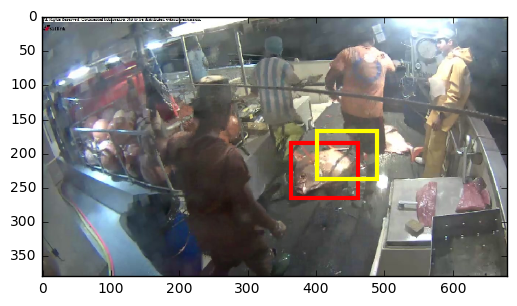

In [24]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    pbb = pval_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb, color='red'))
    plt.gca().add_patch(create_rect(pbb, color='yellow'))

show_bb(352)

In [25]:
# metrics.log_loss(val_labels, do_clip(sum(pvalsls)/len(pvalsls), .9999))
preds = sum(predsls)/len(predsls)
subm = do_clip(preds, clip)

if full:
    subm_name = path+'results/subm_full_conv_' + timestr + '.csv' #'.csv.gz'
else:
    subm_name = path+'results/subm_part_conv_' + timestr + '.csv' #'.csv.gz'

classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.to_csv(subm_name, index=False)#, compression='gzip')
log.info('Done - files @ ' + subm_name)

[2017-03-02 22:30:47.113672] INFO: Logbook: Done - files @ ../data/fish/results/subm_full_conv_20170302.csv


In [26]:
FileLink(subm_name)

/home/ubuntu/fish/data/fish/results/subm_full_conv_20170302.csv